In [303]:
import copy
from collections import Counter
import numpy as np
from matplotlib import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

np.random.seed(100)
torch.manual_seed(100)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.__version__

'1.3.0'

In [231]:
raw_data = 'data/all_couplets.txt'
vocab_size = 2000

### 划分数据集

In [3]:
def split_dataset(raw_data, test_size=3000):
    with open(raw_data, 'r') as f:
        lines = f.readlines()
        
    lines = list(map(str.strip, lines))
    
    np.random.shuffle(lines)
    
    train_lines = lines[test_size:]
    test_lines = lines[:test_size]
        
    return train_lines, test_lines

In [4]:
train_lines, test_lines = split_dataset(raw_data, test_size=3000)
len(train_lines), len(test_lines)

(771491, 3000)

### 获取字符表

In [5]:
def create_vocab(train_lines, size=-1):
    counter = Counter(''.join(train_lines))
    vocab = sorted(counter, key=lambda c: counter[c], reverse=True)
    
    if size != -1:
        vocab = vocab[:size]
    
    print(f"last character: {vocab[-1]}, frequency: {counter[vocab[-1]]}")
        
    return vocab

In [6]:
vocab = create_vocab(train_lines, size=vocab_size)

last character: 辣, frequency: 771


In [36]:
def create_index_char(vocab):
    vocab = vocab.copy()
    vocab = ['<MASK>', '<UNK>', '<BOS>', '<EOS>'] + vocab
    return dict(zip(range(0, len(vocab)), vocab)), dict(zip(vocab, range(0, len(vocab))))

In [37]:
index2char, char2index = create_index_char(vocab)

### 创建数据集

In [239]:
class Couplets_dataset(Dataset):
    def __init__(self, lines, char2index, min_len=10, max_len=20):
        self.min_len = min_len
        self.max_len = max_len
        
        ups = []
        downs = []
        
        for line in lines:  
            if '；' in line:
                line_split = tuple(line.split('；'))
                if len(line_split) == 2:
                    up, down = line_split
            else:
                continue
                
            down = down[:-1]
            if len(up) != len(down):
                continue
                
            up_len = len(up)
            if up_len < min_len or up_len > max_len:
                continue
            
            ups.append(up)
            downs.append(down)
            
        self.ups = ups
        self.downs = downs
        
    def __getitem__(self, index):
        up, down = self.ups[index], self.downs[index]
        down = ['<BOS>'] + list(down) + ['<EOS>']
        
        up_len = len(up)
        if up_len < self.max_len:
            up = list(up) + ['<MASK>'] * (self.max_len - up_len)
            down = down + ['<MASK>'] * (self.max_len - up_len)
        
        x = torch.tensor([char2index.get(c, char2index['<UNK>']) for c in up], dtype=torch.long)
        y = torch.tensor([char2index.get(c, char2index['<UNK>']) for c in down])
        
        return x, y
    
    def __len__(self):
        return len(self.ups)

In [240]:
train_set = Couplets_dataset(train_lines, char2index, min_len=5, max_len=15)
test_set = Couplets_dataset(test_lines, char2index, min_len=5, max_len=15)

len(train_set), len(test_set)

(644701, 2481)

In [241]:
# Test

X, Y = train_set[6]
X.size(), Y.size()

(torch.Size([15]), torch.Size([17]))

In [243]:
# Test

[index2char[i.item()] for i in train_set[6][1]]

['<BOS>',
 '诚',
 '心',
 '待',
 '民',
 '铸',
 '<UNK>',
 '魂',
 '<EOS>',
 '<MASK>',
 '<MASK>',
 '<MASK>',
 '<MASK>',
 '<MASK>',
 '<MASK>',
 '<MASK>',
 '<MASK>']

In [244]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

In [245]:
# Test

X, Y = next(iter(train_loader))
X.size(), Y.size()

(torch.Size([256, 15]), torch.Size([256, 17]))

### 构建网络

#### encoder

In [44]:
class Couplet_encoder(nn.Module):
    def __init__(self, embedding_layer, hidden_dim=200, layer_num=2):
        super().__init__()
        
        self.embedding = embedding_layer
        self.bilstm = nn.LSTM(embedding_layer.weight.size(1), hidden_dim, layer_num,
                              batch_first=True, bidirectional=True)
        
    def forward(self, X):
        X = self.embedding(X)
        X = self.bilstm(X)
        return X

In [45]:
# Test

embedding_layer = nn.Embedding(len(char2index), 100)
encoder = Couplet_encoder(embedding_layer)

X, Y = next(iter(train_loader))
output, (h_n, c_n) = encoder(X)
output.size(), h_n.size(), c_n.size()

(torch.Size([256, 15, 400]),
 torch.Size([4, 256, 200]),
 torch.Size([4, 256, 200]))

#### attention

In [177]:
class Attention_layer(nn.Module):
    def __init__(self, encoder_output_dim, decoder_h_dim):
        super().__init__()
        
        self.fc = nn.Linear(encoder_output_dim + decoder_h_dim, 1)
        self.softmax = nn.Softmax(1)
        
    def forward(self, encoder_output, decoder_h):
        decoder_h_repeat = torch.stack([decoder_h] * encoder_output.size(1), 1)
        merge = torch.cat((encoder_output, decoder_h_repeat), dim=2)
        merge = merge.view(merge.size(0) * merge.size(1), merge.size(2))
        
        X = self.fc(merge).view(encoder_output.size(0), encoder_output.size(1))
        attention_weights = self.softmax(X).view(X.size(0), X.size(1), 1)
        
        return (attention_weights * encoder_output).sum(dim=1)

In [178]:
# Test

encoder_output = torch.randn(100, 15, 40)
decoder_h = torch.randn(100, 40)

attention_layer = Attention_layer(encoder_output.size(-1), decoder_h.size(-1))
attention_layer(encoder_output, decoder_h).size()

torch.Size([100, 40])

#### decoder

In [251]:
class Couplet_decoder(nn.Module):
    def __init__(self, embedding_layer, attention_layer, encoder_output_dim, 
                 encoder_state_dim, bos_index, hidden_dim=200):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.bos_index = bos_index
        
        self.embedding = embedding_layer
        self.attention = attention_layer
        
        self.h_project_fc = nn.Linear(encoder_state_dim, hidden_dim * 2)
        self.c_project_fc = nn.Linear(encoder_state_dim, hidden_dim * 2)
        
        self.lstm_cell_0 = nn.LSTMCell(embedding_layer.weight.size(1) + encoder_output_dim, hidden_dim)
        self.lstm_cell_1 = nn.LSTMCell(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, embedding_layer.weight.size(0))
        
    def forward(self, X, encoder_output, encoder_last_state):
        encoder_last_h, encoder_last_c = encoder_last_state
        decoder_input_h, decoder_input_c = self.h_project_fc(encoder_last_h), self.c_project_fc(encoder_last_c)
        
        decoder_h_0, decoder_h_1 = decoder_input_h[:, :self.hidden_dim], decoder_input_h[:, self.hidden_dim:]
        decoder_c_0, decoder_c_1 = decoder_input_c[:, :self.hidden_dim], decoder_input_h[:, self.hidden_dim:]
        
        X_step = torch.full((X.size(0),), self.bos_index, dtype=torch.long, device=device)

        outputs = []        
        for i in range(X.size(1)):
            embedding_step = self.embedding(X_step)
            attention_step = self.attention(encoder_output, torch.cat([decoder_h_0, decoder_h_1], dim=1))

            input_step = torch.cat([embedding_step, attention_step], dim=1)
            
            decoder_h_0, decoder_c_0 = self.lstm_cell_0(input_step, (decoder_h_0, decoder_c_0))
            decoder_h_1, decoder_c_1 = self.lstm_cell_1(decoder_h_0, (decoder_h_1, decoder_c_1))
            Y_step = self.fc(decoder_h_1)
            outputs.append(Y_step)
            
            X_step = X[:, i]
            
        return torch.stack(outputs, dim=1)

In [252]:
# Test

X = torch.ones(100, 15, dtype=torch.long)
encoder_last_state = torch.randn(100, 20), torch.randn(100, 20)

encoder_output = torch.randn(100, 15, 40)
decoder_h = torch.randn(100, 80)
attention_layer = Attention_layer(encoder_output.size(-1), decoder_h.size(-1))

embedding_layer = nn.Embedding(len(char2index), 120)


decoder = Couplet_decoder(embedding_layer, attention_layer, encoder_output_dim=40, encoder_state_dim=20,
                          bos_index=char2index['<BOS>'], hidden_dim=40)
decoder(X, encoder_output, encoder_last_state).size()

torch.Size([100, 15, 2004])

#### Beam search

In [253]:
class Beam_searcher(nn.Module):
    def __init__(self, decoder, eos_index):
        super().__init__()
        
        self.decoder = decoder
        self.eos_index = eos_index
        self.softmax = nn.Softmax(-1)
        
    def _beam_score(self, Y_prob, alpha=0.7):
        return ((1 / Y_prob.size(1)) ** alpha) * Y_prob.log().sum(dim=1)
    
    def _pick_beam_width(self, best_probs_list, step_probs_list, alpha=0.7):
        score_indices = []
        
        for i in range(len(best_probs_list)):
            best_probs = best_probs_list[i]
            step_probs = step_probs_list[i]
            step_prob_list = list(torch.split(step_probs, 1, dim=1))
            
            for j in range(len(step_prob_list)):
                probs = torch.cat([best_probs, step_prob_list[j]], dim=1)
                score = self._beam_score(probs, alpha).item()               
                score_indices.append((score, i, j))

        sorted_score_indices = sorted(score_indices, key=lambda x: x[0], reverse=True)
        
        return sorted_score_indices
        
    def forward(self, encoder_output, encoder_last_state, beam_width=3, alpha=0.7, max_len=15):
        encoder_last_h, encoder_last_c = encoder_last_state
        decoder_input_h = self.decoder.h_project_fc(encoder_last_h)
        decoder_input_c = self.decoder.c_project_fc(encoder_last_c)
        
        hidden_dim = decoder_input_h.size(-1) // 2
        
        decoder_h_0, decoder_h_1 = decoder_input_h[:, :hidden_dim], decoder_input_h[:, hidden_dim:]
        decoder_c_0, decoder_c_1 = decoder_input_c[:, :hidden_dim], decoder_input_h[:, hidden_dim:]
        
        best_output_list = [torch.tensor([[self.eos_index]] * encoder_output.size(0), 
                                         dtype=torch.long, device=device, requires_grad=False)]
        best_probs_list = None
        best_state_0_list = [(decoder_h_0, decoder_c_0)]
        best_state_1_list = [(decoder_h_1, decoder_c_1)]
        
        for _ in range(max_len):
            step_probs_list = []
            step_indices_list = []
            step_state_0_list = []
            step_state_1_list = []
            
            for i in range(1 if best_probs_list is None else beam_width):
                X_step = best_output_list[i][:, -1]
                decoder_h_0, decoder_c_0 = best_state_0_list[i]
                decoder_h_1, decoder_c_1 = best_state_1_list[i]
            
                embedding_step = self.decoder.embedding(X_step)
                attention_step = self.decoder.attention(encoder_output, 
                                                        torch.cat([decoder_h_0, decoder_h_1], dim=1))
                input_step = torch.cat([embedding_step, attention_step], dim=1)
            
                decoder_h_0, decoder_c_0 = self.decoder.lstm_cell_0(input_step, (decoder_h_0, decoder_c_0))
                decoder_h_1, decoder_c_1 = self.decoder.lstm_cell_1(decoder_h_0, (decoder_h_1, decoder_c_1))
                Y_step = self.decoder.fc(decoder_h_1)
                Y_step = self.softmax(Y_step)
                
                sorted_probs, sorted_indices = Y_step.sort(dim=1, descending=True)
                step_probs = sorted_probs[:, :beam_width]
                step_indices = sorted_indices[:, :beam_width]
                
                step_probs_list.append(step_probs)
                step_indices_list.append(step_indices)                
                step_state_0_list.append((decoder_h_0, decoder_c_0))
                step_state_1_list.append((decoder_h_1, decoder_c_1))
                
            if best_probs_list is None:
                best_probs_list = list(torch.split(step_probs_list[0], 1, dim=1))
                best_output_list = list(torch.split(step_indices_list[0], 1, dim=1))
                best_state_0_list = step_state_0_list * 3
                best_state_1_list = step_state_1_list * 3
            else:
                sorted_score_indices = self._pick_beam_width(best_probs_list, step_probs_list, alpha)
                    
                temp_best_probs_list = []
                temp_best_output_list = []
                best_state_0_list = []
                best_state_1_list = []
                for j in range(beam_width):
                    score, ii, jj = sorted_score_indices[j]
                    best_probs = torch.cat([best_probs_list[ii], 
                                            torch.split(step_probs_list[ii], 1, dim=1)[jj]],
                                           dim=1)
                    best_output = torch.cat([best_output_list[ii],
                                           torch.split(step_indices_list[ii], 1, dim=1)[jj]],
                                           dim=1),
                    temp_best_probs_list.append(best_probs)
                    temp_best_output_list.append(best_output[0])
                    best_state_0_list.append(step_state_0_list[ii])
                    best_state_1_list.append(step_state_1_list[ii])
                    
                best_probs_list = temp_best_probs_list.copy()
                best_output_list = temp_best_output_list.copy()
                
        best_probs = torch.cat(best_probs_list, dim=0)
        best_outputs = torch.cat(best_output_list, dim=0) 
        scores = self._beam_score(best_probs, alpha)
        
        return best_output[torch.argmax(scores)]

In [255]:
# Test

encoder_output = torch.randn(1, 15, 40)
encoder_last_state = torch.randn(1, 20), torch.randn(1, 20)
beam_searcher = Beam_searcher(decoder, char2index['<EOS>'])

with torch.no_grad():
    output = beam_searcher(encoder_output, encoder_last_state)
    
output

tensor([[1775, 1775, 1775, 1077, 1076, 1076, 1076, 1076, 1076, 1076, 1064, 1076,
         1064, 1064,  786]])

#### 整合模型

In [256]:
class Couplet_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, eos_index):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = Attention_layer(2 * hidden_dim, 2 * hidden_dim)
        self.encoder = Couplet_encoder(self.embedding, hidden_dim, 2)
        self.decoder = Couplet_decoder(self.embedding, self.attention, hidden_dim * 2, hidden_dim * 4, hidden_dim)
        self.beamsearcher = Beam_searcher(self.decoder, eos_index)
        
    def forward(self, X, Y):
        encoder_output, (encoder_h, encoder_c) = self.encoder(X)
        encoder_h = encoder_h.transpose(1, 0)
        encoder_h = encoder_h.reshape(encoder_h.size(0), -1)
        encoder_c = encoder_c.transpose(1, 0)
        encoder_c = encoder_c.reshape(encoder_c.size(0), -1)
        encoder_last_state = (encoder_h, encoder_c)
        
        decoder_output = self.decoder(Y, encoder_output, encoder_last_state)
        
        return decoder_output
    
    def beam_search(self, X, beam_width=3, alpha=0.7, max_len=15):
        encoder_output, (encoder_h, encoder_c) = self.encoder(X)
        encoder_h = encoder_h.transpose(1, 0)
        encoder_h = encoder_h.reshape(encoder_h.size(0), -1)
        encoder_c = encoder_c.transpose(1, 0)
        encoder_c = encoder_c.reshape(encoder_c.size(0), -1)
        encoder_last_state = (encoder_h, encoder_c)
        
        output = self.beamsearcher(encoder_output, encoder_last_state, beam_width, alpha, max_len)
        
        return output

In [257]:
# Test

net = Couplet_net(len(char2index), 100, 200, char2index['<BOS>'])

X = torch.ones(50, 10, dtype=torch.long)
Y = torch.ones(50, 10, dtype=torch.long)
net(X, Y).size()

torch.Size([50, 10, 2004])

In [258]:
# Test

X = torch.ones(1, 15, dtype=torch.long)
net.beam_search(X).size()

torch.Size([1, 15])

In [259]:
# Test

X, Y = next(iter(train_loader))
net(X, Y).size()

torch.Size([256, 17, 2004])

### 模型训练

In [260]:
net = Couplet_net(len(char2index), 100, 200, char2index['<BOS>'])

#### 搜索最大学习率

In [293]:
class Lr_finder:
    def __init__(self, model, dataloader, loss_fn, optimizer):
        if torch.cuda.is_available():
            self.model = model.to('cuda')
        else:
            self.model = model

        self.dataloader = dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn

    def lr_find(self, steps=150, repeat=5, lr_range=(1e-4, 10), plot=True):
        self.model.train()

        old_state = copy.deepcopy(self.model.state_dict())

        history_loss = []
        history_lr = []

        for i in range(repeat):
            step = 0
            losses = []
            lrs = []
            stop_flag = False
            while True:
                for X, Y in self.dataloader:
                    if torch.cuda.is_available():
                        X, Y = X.to('cuda'), Y.to('cuda')

                    lr = self.exp_lr_scheduler(step, steps, lr_range)
                    self.optimizer.param_groups[0]['lr'] = lr

                    outputs = self.model(X, Y)
                    loss = self.loss_fn(outputs, Y)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    losses.append(loss.item())
                    lrs.append(lr)

                    step += 1
                    if step == steps:
                        stop_flag = True
                        break

                if stop_flag:
                    break

            self.model.load_state_dict(old_state)

            history_loss.append(losses)
            history_lr.append(lrs)

        x = np.array(history_lr).mean(axis=0)
        y = np.array(history_loss).mean(axis=0)

        if plot:
            plt.xscale('log')
            plt.xlabel('lr')
            plt.ylabel('loss')
            plt.title('loss_lr curve')
            plt.plot(x, y)
        else:
            return x, y

    def exp_lr_scheduler(self, step, steps, lr_range):
        pct = step / (steps - 1)
        return lr_range[0] * (lr_range[1] / lr_range[0]) ** pct

In [294]:
def create_loss():
    loss_fn = nn.CrossEntropyLoss()

    def new_loss_fn(outputs, labels):
        outputs = outputs.reshape((-1, outputs.size(-1)))
        labels = labels.reshape((-1))
        loss = loss_fn(outputs, labels)
        return loss
    
    return new_loss_fn

In [295]:
lr_finder = Lr_finder(net, train_loader, create_loss(),
                      optim.SGD(net.parameters(), 0.1, weight_decay=0))

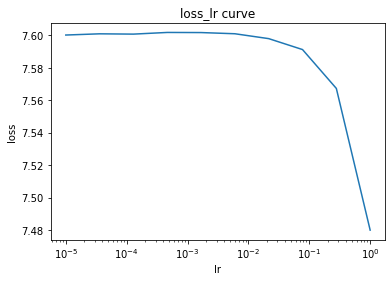

In [297]:
lr_finder.lr_find(steps=10, lr_range=(1e-5, 1), plot=True, repeat=1)

#### 训练

In [317]:
class Learner:
    def __init__(self, model):
        if torch.cuda.is_available():
            self.model = model.to('cuda')
        else:
            self.model = model

    def fit(self, dataloader, lr, epochs, weight_decay=0, print_steps=200):
        self.model.train()

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=0.9,
                              weight_decay=weight_decay, nesterov=False)
        scheduler = lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                            steps_per_epoch=len(dataloader))

        history_loss = []
        history_steps = []
        for epoch in range(epochs):
            for step, (X, Y) in enumerate(dataloader):
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X, Y)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if step % print_steps == print_steps - 1:
                    history_loss.append(loss.item())
                    history_steps.append(epoch * len(dataloader) + step + 1)
                    print(f"epoch: {epoch + 1}    \tstep: {step + 1}    \tloss: {loss:.4f}")

        return history_steps, history_loss

    def evaluate(self, dataloader):
        self.model.eval()
        
        loss_fn = nn.CrossEntropyLoss()

        losses = []

        with torch.no_grad():
            for X, Y in dataloader:
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                losses.append(loss.item())

        return np.average(losses)

    
    def beam_search(self, up, beam_width=3, alpha=0.7, max_len=15):
        up = [char2index[x] for x in up]
        up = torch.tensor(up, dtype=torch.long, device=device)
        up = up.view(1, -1)
        
        down = self.model.beam_search(up, beam_width, alpha, max_len).squeeze().cpu().numpy()
        down = [index2char[x] for x in down if x != char2index['<MASK>']]
        
        return ''.join(down)

In [318]:
learn = Learner(net)

In [309]:
learn.fit(train_loader, 0.01, 1, weight_decay=0, print_steps=10)

epoch: 1    	step: 10    	loss: 7.5820
epoch: 1    	step: 20    	loss: 7.5687
epoch: 1    	step: 30    	loss: 7.5488
epoch: 1    	step: 40    	loss: 7.5287


KeyboardInterrupt: 

In [319]:
learn.beam_search('白日依山尽')

[   0    0    0    0    0    0    0    0    0    0    0    0    0 1495
    0]


'杖'